# Behavioral Cloning Model

Steps below:  
0 - Load the libraries  
1 - Load and explore driving logs  
2 - Load and explore images  
3 - Data pre-processing and augmentation   
4 - Image and batch generators  
5 - Model training  

### 0 - Load the libraries

In [1]:
# Load libraries
import os
import cv2
import argparse
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from random import randint, uniform
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam

Using TensorFlow backend.


### 1 - Load and explore driving logs

In [2]:
# Load driving log and display top 5 rows
driving_log = pd.read_csv('./data/driving_log.csv')
driving_log.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [3]:
# Summaries
print("Number of examples =", len(driving_log))
print("Average steering angles =", np.mean(driving_log['steering']))
print("Average throttle =", np.mean(driving_log['throttle']))
print("Average brake =", np.mean(driving_log['brake']))
print("Average speed =", np.mean(driving_log['speed']))

Number of examples = 8036
Average steering angles = 0.00406964406483
Average throttle = 0.869659511198
Average brake = 0.00196980435665
Average speed = 28.1698391413


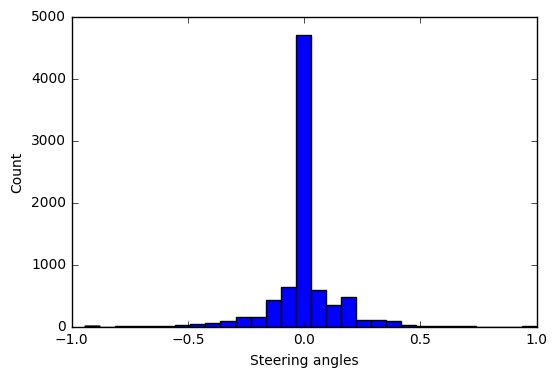

In [4]:
# Plot the distribution of steering angles
plt.hist(driving_log['steering'], bins=30)
plt.xlabel('Steering angles')
plt.ylabel('Count')

### 2 - Load and explore images

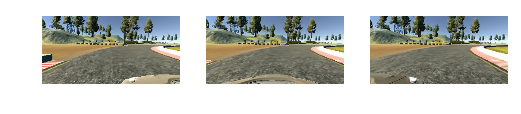

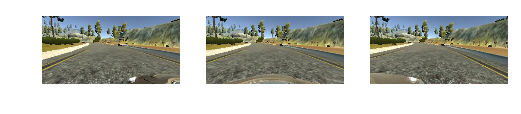

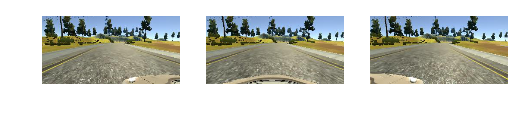

In [5]:
# Look at few examples for left, center and right camera images
cam = ['left', 'center', 'right']

for i in range(1, 4):
    index = randint(0, len(driving_log)-1)
    # Plot all three images from the same driving record
    for pos in cam:
        plt.subplot(i, 3, cam.index(pos) + 1)
        img = cv2.imread('data/IMG/'+ os.path.basename(driving_log[pos][index]))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

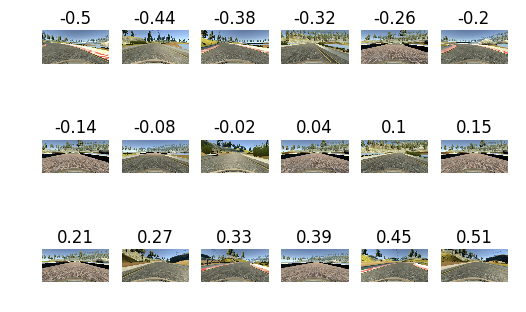

In [6]:
# Look at 18 center camera images for steering angle [-0.5, 0.5]
for i in range(18):
    steer = round(-0.5+i/16.8, 2)
    for n in range(len(driving_log['steering'])):
        if round(driving_log['steering'][n], 2) == steer:
            plt.subplot(3, 6, i+1)
            img = cv2.imread('data/IMG/'+ os.path.basename(driving_log['center'][n]))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(steer)
            break        

### 3 - Data pre-processing and augmentation

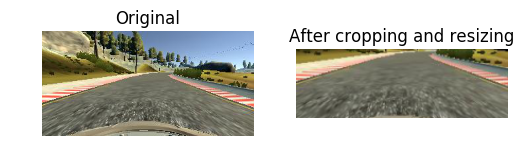

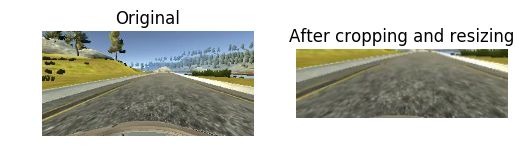

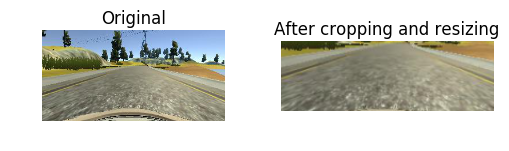

In [7]:
# Cropping and resizing to match Nvidia network input plane
def preprocessImg(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[60:140, 40:280]
    return cv2.resize(img, (200, 66), interpolation=cv2.INTER_AREA)

# Test effects
for i in range(1, 4):
    index = randint(0, len(driving_log)-1)
    img = cv2.imread('data/IMG/'+ os.path.basename(driving_log['center'][index]))
    plt.subplot(i, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')
    plt.subplot(i, 2, 2)
    plt.imshow(preprocessImg(img))
    plt.title('After cropping and resizing')
    plt.axis('off')
    plt.show()

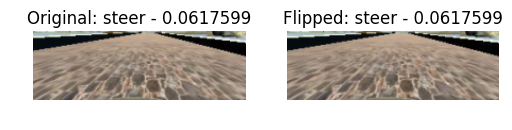

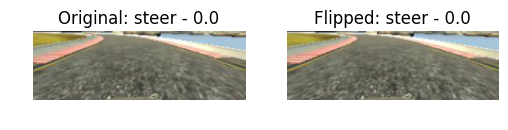

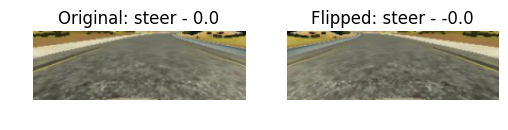

In [8]:
# Random horizontal flips
def flip(img, steer):
    rand = randint(0, 2) 
    if rand == 0:
        img, steer = cv2.flip(img, 1), -steer
    return img, steer

# Test effects on pre-processed images
for i in range(1, 4):
    index = randint(0, len(driving_log)-1)
    img = preprocessImg(cv2.imread('data/IMG/'+ os.path.basename(driving_log['center'][index])))
    steer = driving_log['steering'][index]
    plt.subplot(i, 2, 1)
    plt.imshow(img)
    plt.title('Original: steer - ' + str(steer))
    plt.axis('off')
    plt.subplot(i, 2, 2)
    img, steer = flip(img, steer)
    plt.imshow(img)
    plt.title('Flipped: steer - ' + str(steer))
    plt.axis('off')
    plt.show()

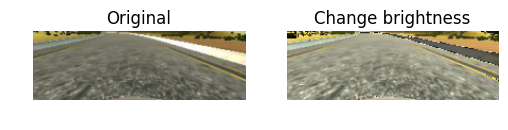

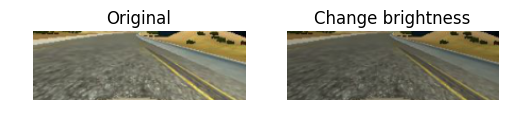

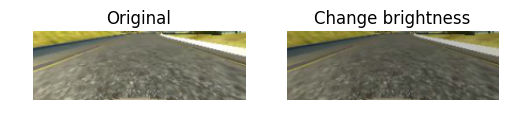

In [9]:
# Changing brightness to simulate day and night conditions
def brightness(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)   
    img[:,:,2] = img[:,:,2] * np.random.uniform(0.5, 1.5)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

# Test effects on pre-processed images
for i in range(1, 4):
    index = randint(0, len(driving_log)-1)
    img = preprocessImg(cv2.imread('data/IMG/'+ os.path.basename(driving_log['center'][index])))
    plt.subplot(i, 2, 1)
    plt.imshow(img)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(i, 2, 2)
    plt.imshow(brightness(img))
    plt.title('Change brightness')
    plt.axis('off')
    plt.show()

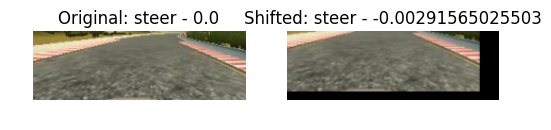

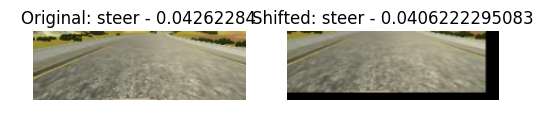

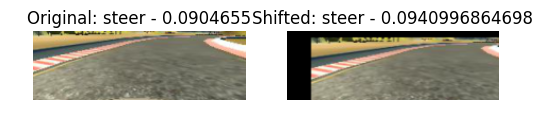

In [10]:
# Shift the images 
# Modified base on Vivek Yadav's blog 
# (https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.o2hyrbli5)
def shift(img, steer):
    tr_x = np.random.uniform(-25, 25)
    steer = steer + tr_x/10000*1.6
    tr_y = np.random.uniform(-10, 10)
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    img= cv2.warpAffine(img, Trans_M, (200, 66))    
    return img, steer

# Test effects on pre-processed images
for i in range(1, 4):
    index = randint(0, len(driving_log)-1)
    img = preprocessImg(cv2.imread('data/IMG/'+ os.path.basename(driving_log['center'][index])))
    steer = driving_log['steering'][index]
    plt.subplot(i, 2, 1)
    plt.imshow(img)
    plt.title('Original: steer - ' + str(steer))
    plt.axis('off')
    plt.subplot(i, 2, 2)
    img, steer = shift(img, steer)
    plt.imshow(img)
    plt.title('Shifted: steer - ' + str(steer))
    plt.axis('off')
    plt.show()

### 4 - Image and batch generators

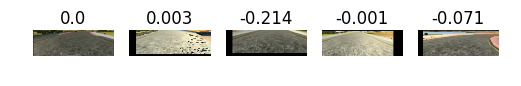

In [11]:
# Image generator
def gen_image(data):
    
    # Using left and right camera images to simulate the effect of car wandering off to the side, and recovering
    # add .25 to the left camera steer angle and subtract 0.25 from the right camera 
    # since the left camera has to move right to get to center, and right camera has to move left
    cam = np.random.randint(3)
    index = randint(0, len(data)-1)
    if cam == 0:
        img = cv2.imread('data/IMG/'+ os.path.basename(data['left'][index]))
        steer = data['steering'][index] + .25
    elif cam == 1:
        img = cv2.imread('data/IMG/'+ os.path.basename(data['center'][index]))
        steer = data['steering'][index]
    else:
        img = cv2.imread('data/IMG/'+ os.path.basename(data['right'][index]))
        steer = data['steering'][index] - .25
        
    img = preprocessImg(img)
    img = brightness(img)
    img, steer = flip(img, steer) 
    img, steer = shift(img, steer)   
    return img, steer  

# Test - make sure it works
for i in range(1, 6):
    plt.subplot(1, 5, i)
    img, steer = gen_image(driving_log)
    plt.imshow(img)
    plt.title(str(round(steer, 3)))
    plt.axis('off')
plt.show()

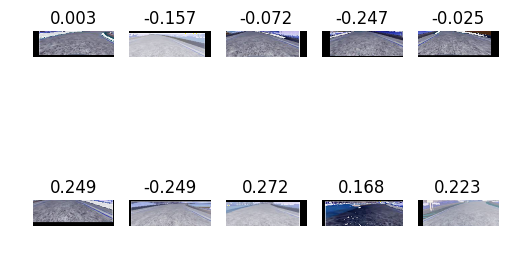

X_batch data type : float64
Y_batch data type : float64


In [12]:
# Batch generator
def gen_batch(data, batch_size):
    x_batch = np.zeros((batch_size, 66, 200, 3))
    y_batch = np.zeros(batch_size)  
    while 1:
        for i in range(batch_size):
            x, y = gen_image(data)
            x_batch[i], y_batch[i] = x, y
        yield x_batch, y_batch

# Test - make sure it works
x_batch = np.zeros((10, 66, 200, 3))
y_batch = np.zeros(10)
x_batch, y_batch = next(gen_batch(driving_log, 10))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_batch[i])
    plt.title(str(round(y_batch[i], 3)))
    plt.axis('off')
plt.show()

print('X_batch data type :', x_batch.dtype)
print('Y_batch data type :', y_batch.dtype)

### 5 - Model training

In [13]:
# Network architecture adapts Nvidia's paper "End to End Learning for Self-Driving Cars"
model = Sequential()
    
# Normalization on the fly from comma ai model
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(66, 200, 3)))
    
#model.add(Convolution2D(3, 1, 1, border_mode='same', name='color_conv'))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="same", init='he_normal'))
model.add(ELU())
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="same", init='he_normal'))
model.add(ELU())
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="same", init='he_normal')) 
model.add(ELU())
model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same", init='he_normal'))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same", init='he_normal'))
model.add(ELU())                         
model.add(Flatten())
#model.add(Dropout(.2))
model.add(Dense(1164, init='he_normal'))
#model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(100, init='he_normal'))
model.add(ELU())
model.add(Dense(50, init='he_normal'))
model.add(ELU())
model.add(Dense(10, init='he_normal'))
model.add(ELU())
model.add(Dense(1, init='he_normal'))

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer="adam", loss="mse")

In [14]:
# Split data into train and validation sets
train, validation = train_test_split(driving_log, test_size=0.10, random_state=1111)
train = train.reset_index()
validation = validation.reset_index()

print("Number of train examples =", len(train))
print("Number of validation examples =", len(validation))
print("Average train steering angles =", np.mean(train['steering']))
print("Average validation steering angles =", np.mean(validation['steering']))

Number of train examples = 7232
Number of validation examples = 804
Average train steering angles = 0.00399650664381
Average validation steering angles = 0.00472751698632


In [15]:
# Train the model
model.fit_generator(
    gen_batch(train, 128),
    samples_per_epoch = 32000,
    nb_epoch = 7,
    validation_data = gen_batch(validation, 128),
    nb_val_samples = 3200, verbose = 1
  )

model.save_weights('model.h5')
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

Epoch 1/7
32000/32000 [==============================] - 363s - loss: 0.3964 - val_loss: 0.0517